In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import scipy.stats
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.irf import IRAnalysis
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [36]:
# Two Volatility Dataframes, reconstructed and benchmark
Volatility = pd.read_csv("Volatility.csv").rename(columns={"regional_timestamp":"Date"}).set_index("Date")[22:]
Benchmark = pd.read_csv("Benchmark.csv").rename(columns={"regional_timestamp":"Date"}).set_index("Date")[22:]
Benchmark = Benchmark.drop(Benchmark.index[~Benchmark.index.isin(Volatility.index)])
# Two Volume Dataframes, Front month deseasoned, VolumeOI deseasoned
Volume = pd.read_csv("Volume1.csv").rename(columns={"Unnamed: 0":"Date"}).set_index("Date")[23:]
VolumeOI = pd.read_csv("VolumeOI.csv").rename(columns={"Calendar Day":"Date"}).set_index("Date")[23:]

Volatility.index = pd.to_datetime(Volatility.index)
Volume.index = pd.to_datetime(Volume.index)
Benchmark.index = pd.to_datetime(Benchmark.index)
VolumeOI.index = pd.to_datetime(VolumeOI.index)

In [37]:
Volatility = Volatility.transform(lambda x : x*100)

In [38]:
len(Volatility),len(Benchmark),len(Volume),len(VolumeOI)

(1193, 1193, 1193, 1193)

In [39]:
Volatility.head(1)
Benchmark.head(1)
Volume.head(1)
VolumeOI.head(1)

,realized_volatility,implied_volatility,difference_lagged,difference
Date,,,,
2017-02-02,8.837903,16.1939,7.626197,7.355997


,realized_volatility,implied_volatility,difference_lagged,difference
Date,,,,
2017-02-02,0.600334,0.161939,-0.435693,-0.438395


,Volume
Date,
2017-02-02,-23537.995587


,Volume
Date,
2017-02-02,-0.037618


# VAR Model 1
- Front Month Volume
- Volatility 3 ways, our calculation.
----------------------------------
1. Implied + Realized
2. Difference without lag
3. Difference with lag

In [40]:
VAR_data1 = pd.concat([Volume, Volatility], axis=1)
VAR_data1_diff_nolag = VAR_data1.drop(columns=["realized_volatility","implied_volatility",'difference_lagged'],inplace=False)
VAR_data1_diff_lag = VAR_data1.drop(columns=["realized_volatility","implied_volatility",'difference'],inplace=False)
VAR_data1.drop(columns=["difference","difference_lagged"],inplace=True)

In [41]:
VAR_data1.head(1)
VAR_data1_diff_nolag.head(1)
VAR_data1_diff_lag.head(1)

,Volume,realized_volatility,implied_volatility
Date,,,
2017-02-02,-23537.995587,8.837903,16.1939


,Volume,difference
Date,,
2017-02-02,-23537.995587,7.355997


,Volume,difference_lagged
Date,,
2017-02-02,-23537.995587,7.626197


In [42]:
model = VAR(VAR_data1)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,32.39,32.40,1.162e+14,32.39
1,28.57,28.62,2.554e+12,28.59
2,28.51,28.60*,2.418e+12,28.55
3,28.49,28.62,2.356e+12,28.54
4,28.47,28.64,2.317e+12,28.53
5,28.44,28.65,2.242e+12,28.52
6,28.42,28.66,2.196e+12,28.51
7,28.38,28.67,2.118e+12,28.49*
8,28.38,28.70,2.119e+12,28.50
9,28.38,28.74,2.117e+12,28.52


In [34]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Dec, 2021
Time:                     07:48:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    29.1169
Nobs:                     1192.00    HQIC:                   29.0850
Log likelihood:          -22385.3    FPE:                4.19845e+12
AIC:                      29.0657    Det(Omega_mle):     4.15646e+12
--------------------------------------------------------------------
Results for equation Volume
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                     -46710.914495     27184.014501           -1.718           0.086
L1.Volume                      0.625156         0.029920           20.894           0.000
L1.realized_volatility 

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12')])

(array([-10000.,  -5000.,      0.,   5000.,  10000.,  15000.,  20000.,
         25000.,  30000.]),
 [Text(0, -10000.0, '−10000'),
  Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000')])

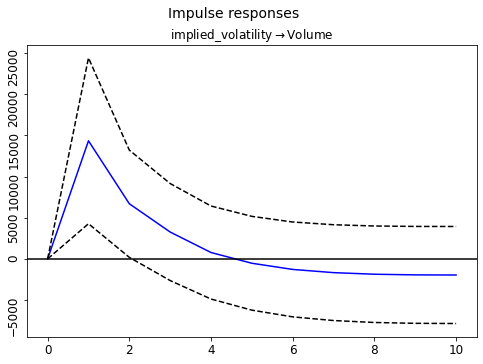

In [10]:
Impulse1 = IRAnalysis(model_fitted)
fig = Impulse1.plot(impulse='implied_volatility',response='Volume',figsize=(8,6));
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.xticks(fontsize=12, rotation=0);
plt.yticks(fontsize=12, rotation=90);
plt.savefig('ImpulseImplied.png', bbox_inches='tight')

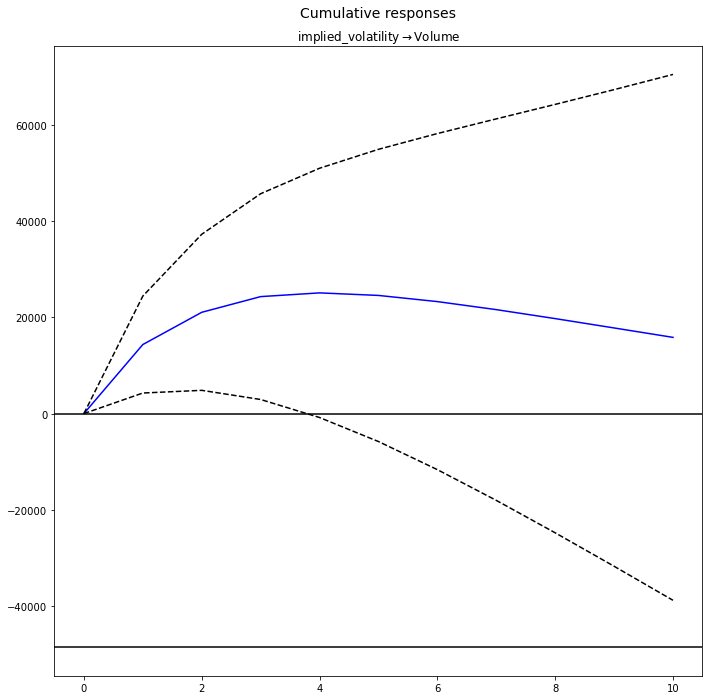

In [11]:
Impulse1.plot_cum_effects(impulse='implied_volatility',response='Volume');
plt.savefig('ImpulseImpliedCUM.png', bbox_inches='tight');

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12')])

(array([-15000., -10000.,  -5000.,      0.,   5000.,  10000.,  15000.]),
 [Text(0, -15000.0, '−15000'),
  Text(0, -10000.0, '−10000'),
  Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000')])

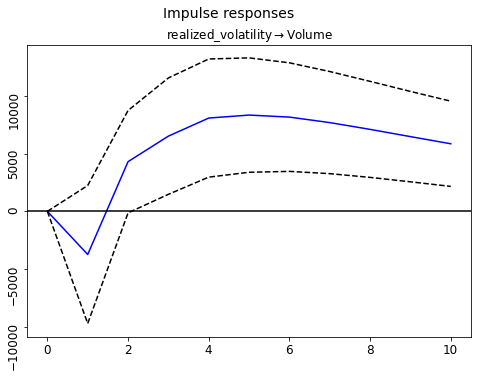

In [12]:
fig = Impulse1.plot(impulse='realized_volatility',response='Volume',figsize=(8,6));
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.xticks(fontsize=12, rotation=0);
plt.yticks(fontsize=12, rotation=90);
plt.savefig('ImpulseRealized.png', bbox_inches='tight')

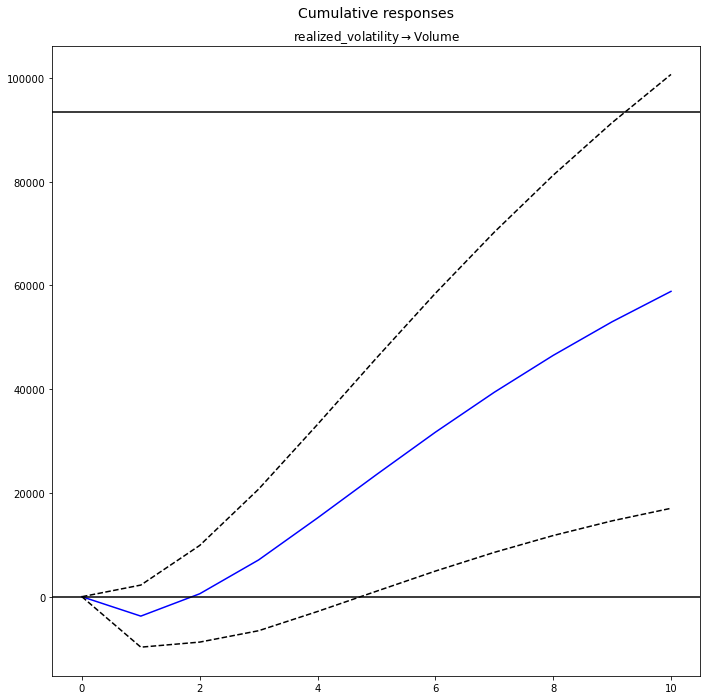

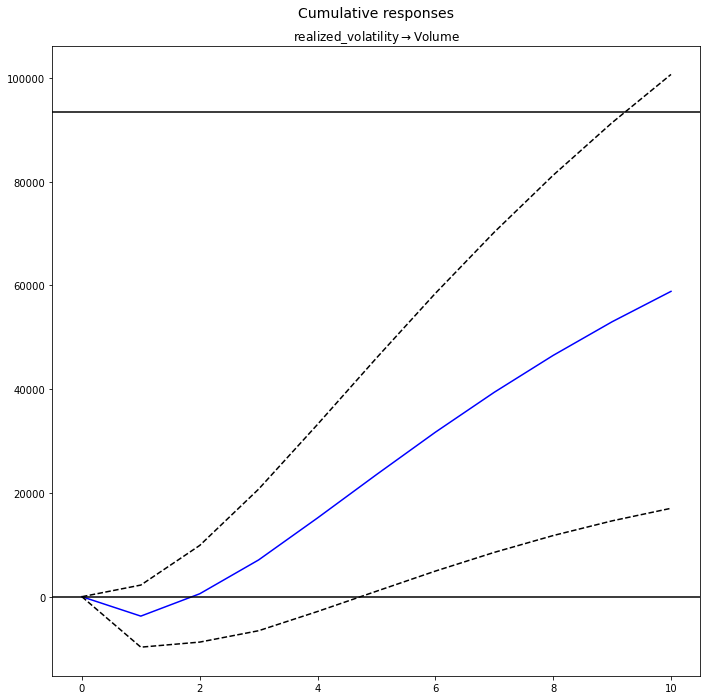

In [13]:
Impulse1.plot_cum_effects(impulse='realized_volatility',response='Volume');
plt.savefig('ImpulseRealizedCUM.png', bbox_inches='tight')

In [14]:
model = VAR(VAR_data1_diff_nolag)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,28.84,28.85,3.366e+12,28.85
1,27.64,27.67,1.012e+12,27.65
2,27.59,27.63,9.584e+11,27.60
3,27.54,27.60,9.168e+11,27.57
4,27.52,27.60,8.981e+11,27.55
5,27.49,27.58,8.665e+11,27.52
6,27.47,27.58,8.516e+11,27.51
7,27.44,27.56*,8.221e+11,27.48*
8,27.43,27.58,8.169e+11,27.48
9,27.43,27.59,8.142e+11,27.49


In [15]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Dec, 2021
Time:                     07:06:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    27.6183
Nobs:                     1191.00    HQIC:                   27.5917
Log likelihood:          -19791.2    FPE:                9.46116e+11
AIC:                      27.5756    Det(Omega_mle):     9.38222e+11
--------------------------------------------------------------------
Results for equation Volume
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const            -62082.327227     21754.117656           -2.854           0.004
L1.Volume             0.697782         0.033693           20.710           0.000
L1.difference     14901.367632      3266.060007            

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12')])

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000.]),
 [Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000')])

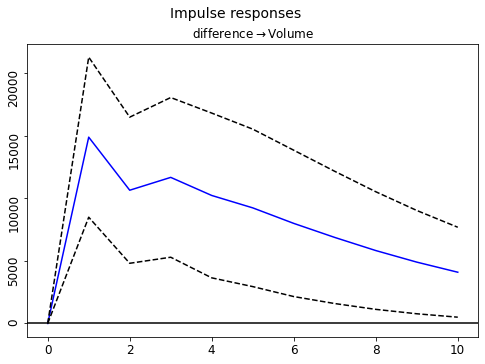

In [16]:
Impulse2 = IRAnalysis(model_fitted)
fig = Impulse2.plot(impulse='difference',response='Volume',figsize=(8,6));
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.xticks(fontsize=12, rotation=0);
plt.yticks(fontsize=12, rotation=90);
plt.savefig('ImpulseDifference.png', bbox_inches='tight')

In [17]:
model = VAR(VAR_data1_diff_lag)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,30.33,30.34,1.490e+13,30.34
1,28.10,28.13,1.603e+12,28.11
2,28.04,28.09*,1.512e+12,28.06
3,28.04,28.10,1.504e+12,28.06
4,28.03,28.11,1.493e+12,28.06
5,28.04,28.13,1.501e+12,28.07
6,28.03,28.14,1.490e+12,28.07
7,28.00,28.13,1.444e+12,28.05*
8,28.00,28.15,1.445e+12,28.05
9,28.00,28.17,1.449e+12,28.06


In [18]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Dec, 2021
Time:                     09:25:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    28.0751
Nobs:                     1191.00    HQIC:                   28.0485
Log likelihood:          -20063.2    FPE:                1.49395e+12
AIC:                      28.0324    Det(Omega_mle):     1.48149e+12
--------------------------------------------------------------------
Results for equation Volume
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    14341.182830     12827.398667            1.118           0.264
L1.Volume                    0.687902         0.036547           18.822           0.000
L1.difference_lagged      7674.

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12')])

(array([-10000.,  -5000.,      0.,   5000.,  10000.,  15000.]),
 [Text(0, -10000.0, '−10000'),
  Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000')])

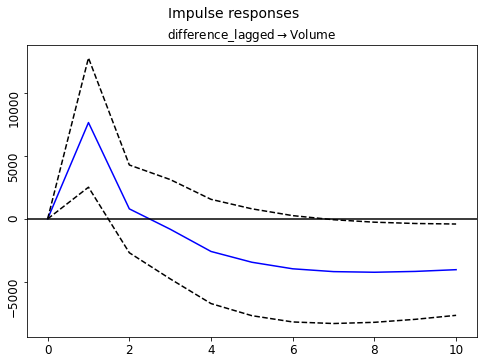

In [19]:
Impulse3 = IRAnalysis(model_fitted)
fig = Impulse3.plot(impulse='difference_lagged',response='Volume',figsize=(8,6));
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.xticks(fontsize=12, rotation=0);
plt.yticks(fontsize=12, rotation=90);
plt.savefig('ImpulseDifferenceLag.png', bbox_inches='tight')

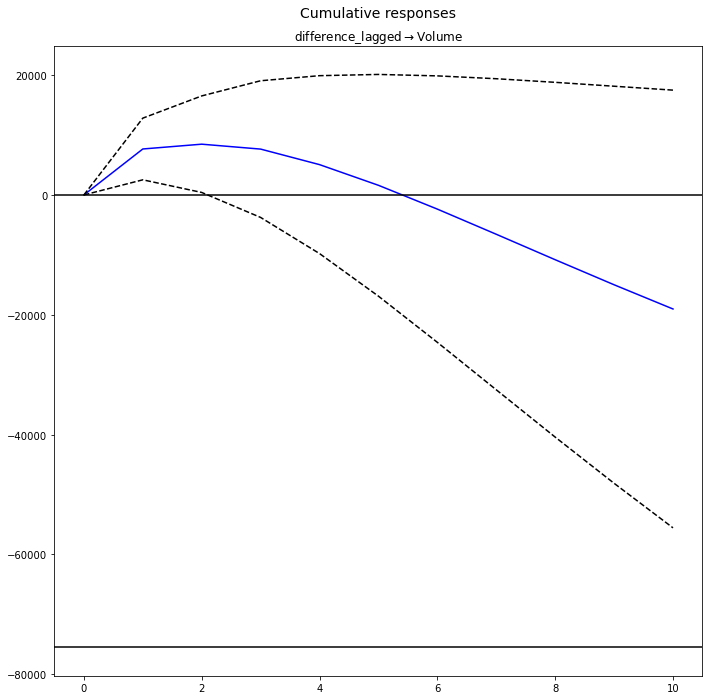

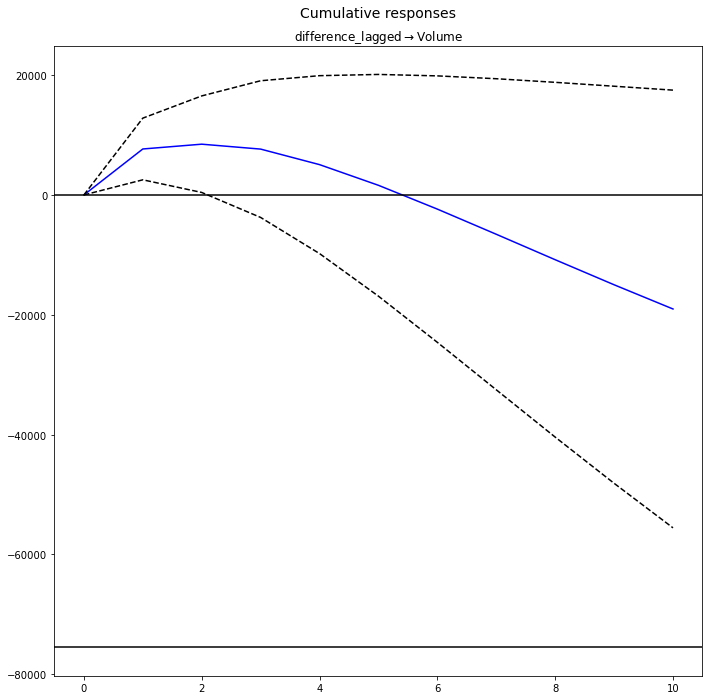

In [20]:
Impulse3.plot_cum_effects(impulse='difference_lagged',response='Volume');
plt.savefig('ImpulseDifferenceCUM.png', bbox_inches='tight')

# VAR Model 2
- Front Month Volume
- Benchmark Volatility 3 ways:
--------------------------------
1. Implied + Realized
2. Difference without lag
3. Difference with lag

In [21]:
VAR_data2 = pd.concat([Volume, Benchmark], axis=1)
VAR_data2_diff_nolag = VAR_data2.drop(columns=["realized_volatility","implied_volatility",'difference_lagged'],inplace=False)
VAR_data2_diff_lag = VAR_data2.drop(columns=["realized_volatility","implied_volatility",'difference'],inplace=False).fillna(method='ffill')
VAR_data2.drop(columns=["difference","difference_lagged"],inplace=True)

In [22]:
model = VAR(VAR_data2)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,18.73,18.74,1.364e+08,18.74
1,11.76,11.81*,1.277e+05,11.78
2,11.74,11.83,1.259e+05,11.78
3,11.74,11.87,1.256e+05,11.79
4,11.68,11.85,1.187e+05,11.75*
5,11.68,11.89,1.182e+05,11.76
6,11.67,11.92,1.175e+05,11.77
7,11.65,11.93,1.145e+05,11.76
8,11.64,11.96,1.137e+05,11.76
9,11.62,11.98,1.113e+05,11.76


In [23]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Dec, 2021
Time:                     09:25:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.7844
Nobs:                     1192.00    HQIC:                   11.7525
Log likelihood:          -12055.1    FPE:                    124644.
AIC:                      11.7332    Det(Omega_mle):         123398.
--------------------------------------------------------------------
Results for equation Volume
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                    -140211.354985     28568.436101           -4.908           0.000
L1.Volume                      0.607232         0.025273           24.027           0.000
L1.realized_volatility 

In [24]:
model = VAR(VAR_data2_diff_nolag)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,24.90,24.91,6.523e+10,24.90
1,20.03,20.06,5.002e+08,20.04
2,20.02,20.06,4.958e+08,20.04
3,20.01,20.07,4.879e+08,20.03
4,19.95,20.03*,4.609e+08,19.98
5,19.95,20.04,4.599e+08,19.98
6,19.95,20.06,4.592e+08,19.99
7,19.92,20.05,4.476e+08,19.97
8,19.91,20.06,4.430e+08,19.96
9,19.90,20.06,4.391e+08,19.96*


In [25]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Dec, 2021
Time:                     09:25:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.0401
Nobs:                     1192.00    HQIC:                   20.0241
Log likelihood:          -15305.4    FPE:                4.92249e+08
AIC:                      20.0145    Det(Omega_mle):     4.89780e+08
--------------------------------------------------------------------
Results for equation Volume
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const            -34360.190065     17487.161819           -1.965           0.049
L1.Volume             0.666804         0.021993           30.318           0.000
L1.difference    -41692.055680     17803.601717           -

In [26]:
pd.notnull(Benchmark).value_counts() # Few rows are missing data is not granural enough

realized_volatility  implied_volatility  difference_lagged  difference
True                 True                True               True          1183
                                         False              True            10
dtype: int64

In [27]:
model = VAR(VAR_data2_diff_lag)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,24.88,24.89,6.410e+10,24.89
1,19.98,20.00,4.747e+08,19.99
2,19.97,20.01,4.700e+08,19.98
3,19.95,20.02,4.638e+08,19.98
4,19.91,19.99*,4.432e+08,19.94
5,19.91,20.00,4.422e+08,19.94
6,19.91,20.02,4.432e+08,19.95
7,19.89,20.02,4.344e+08,19.94
8,19.89,20.03,4.330e+08,19.94
9,19.87,20.03,4.264e+08,19.93*


In [28]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Dec, 2021
Time:                     09:25:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.9879
Nobs:                     1192.00    HQIC:                   19.9720
Log likelihood:          -15274.3    FPE:                4.67233e+08
AIC:                      19.9623    Det(Omega_mle):     4.64890e+08
--------------------------------------------------------------------
Results for equation Volume
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                   -43160.305068     17588.193236           -2.454           0.014
L1.Volume                    0.658931         0.022423           29.386           0.000
L1.difference_lagged    -52405.

# Structural Breaks on Model 1

In [29]:
VAR_data1.head(1050)

,Volume,realized_volatility,implied_volatility
Date,,,
2017-02-02,-23537.995587,8.837903,16.1939
2017-02-03,-54932.738897,9.464721,15.1332
2017-02-06,488004.007571,11.440489,16.4328
2017-02-07,64470.445165,8.552389,16.9147
2017-02-08,374958.159980,12.015388,16.8310
...,...,...,...
2021-03-17,-246591.797477,6.335072,17.5706
2021-03-18,-134034.294140,8.339464,17.4622
2021-03-19,-83936.005589,12.989203,18.3950


In [43]:
# For the impl/realized
X_pre_covid = sm.add_constant(((VAR_data1[0:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data1[0:787].drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data1[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data1[787:].drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data1.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data1.drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [44]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 2
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("We cannot confirm the structural break on 95% confidence.")

CHOW TEST: 
Chow statistic is 104.15
Table value of the F distribution is 3.0
We can confirm the structural break on 95% confidence.


In [40]:
# For the difference_lagged
X_pre_covid = sm.add_constant(((VAR_data1_diff_lag[:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data1_diff_lag[:787].drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data1_diff_lag[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data1_diff_lag[787:].drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data1_diff_lag.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data1_diff_lag.drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [41]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 1
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We cannot confirm the structural break on 95% confidence.")

CHOW TEST: 
Chow statistic is 210.93
Table value of the F distribution is 3.85
We can confirm the structural break on 95% confidence.


In [34]:
# For the difference_without_lag
X_pre_covid = sm.add_constant(((VAR_data1_diff_nolag[:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data1_diff_nolag[:787].drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data1_diff_nolag[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data1_diff_nolag[787:].drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data1_diff_nolag.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data1_diff_nolag.drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [37]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 1
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
#Chow_statistic = Chow_statistic[0]
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We cannot confirm the structural break on 95% confidence.")

CHOW TEST: 
Chow statistic is 89.11
Table value of the F distribution is 3.85
We can confirm the structural break on 95% confidence.


In [47]:
print(result_full.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     600.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          5.20e-181
Time:                        09:28:28   Log-Likelihood:                -16834.
No. Observations:                1193   AIC:                         3.367e+04
Df Residuals:                    1190   BIC:                         3.369e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.005e+05   2

In [46]:
print(result_pre.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     476.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          3.09e-136
Time:                        09:28:05   Log-Likelihood:                -11041.
No. Observations:                 787   AIC:                         2.209e+04
Df Residuals:                     784   BIC:                         2.210e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -8.374e+05   4

In [45]:
print(result_post.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     326.8
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           4.46e-85
Time:                        09:27:38   Log-Likelihood:                -5696.4
No. Observations:                 406   AIC:                         1.140e+04
Df Residuals:                     403   BIC:                         1.141e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.958e+05   5

In [ ]:
VAR_data1_diff_nolag[1000:]

# Structural Breaks on Model 2

In [ ]:
VAR_data2.head(788)

In [48]:
# For the impl/realized
X_pre_covid = sm.add_constant(((VAR_data2[0:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data2[0:787].drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data2[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data2[787:].drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data2.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data2.drop(columns=['implied_volatility','realized_volatility'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [49]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 2
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("We cannot confirm the structural break on 95% confidence.")

CHOW TEST: 
Chow statistic is 130.31
Table value of the F distribution is 3.0
We can confirm the structural break on 95% confidence.


In [54]:
print(result_post.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     149.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           2.96e-49
Time:                        09:37:22   Log-Likelihood:                -5779.5
No. Observations:                 406   AIC:                         1.157e+04
Df Residuals:                     403   BIC:                         1.158e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.834e+05   5

In [ ]:
# For the difference_lagged
X_pre_covid = sm.add_constant(((VAR_data2_diff_lag[0:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data2_diff_lag[0:787].drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data2_diff_lag[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data2_diff_lag[787:].drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data2_diff_lag.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data2_diff_lag.drop(columns=['difference_lagged'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [ ]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 1
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We cannot confirm the structural break on 95% confidence.")

In [ ]:
# For the difference_nolag
X_pre_covid = sm.add_constant(((VAR_data2_diff_nolag[0:787].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_pre_covid = ((VAR_data2_diff_nolag[0:787].drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_post_covid = sm.add_constant(((VAR_data2_diff_nolag[787:].drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_post_covid  = ((VAR_data2_diff_nolag[787:].drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)
X_total = sm.add_constant(((VAR_data2_diff_nolag.drop(columns='Volume',inplace=False)).reset_index()).drop(columns="Date",inplace=False))
Y_total = ((VAR_data2_diff_nolag.drop(columns=['difference'],inplace=False)).reset_index()).drop(columns="Date",inplace=False)

In [ ]:
model_pre = sm.OLS(Y_pre_covid,X_pre_covid)
model_post = sm.OLS(Y_post_covid,X_post_covid)
model_full = sm.OLS(Y_total,X_total)
result_pre = model_pre.fit()
result_post = model_post.fit()
result_full = model_full.fit()

SQER = ((result_full.resid)**2).sum()
SQE1 = ((result_pre.resid)**2).sum()
SQE2 = ((result_post.resid)**2).sum()
k = 1
N = 1193

Numerator = (SQER - (SQE1 + SQE2))/k
Denominator = (SQE1 + SQE2) / (N-2*k)

Chow_statistic = Numerator / Denominator
F_table_value = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=1193)

print("CHOW TEST: ")
if Chow_statistic>F_table_value:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We can confirm the structural break on 95% confidence.")
else:
    print("Chow statistic is "+ str(round(Chow_statistic,2)))
    print("Table value of the F distribution is "+ str(round(F_table_value,2))) 
    print("We cannot confirm the structural break on 95% confidence.")

In [ ]:
VAR_data1_diff_nolag['sign_counter'] = np.sign(VAR_data1_diff_nolag.difference)

In [ ]:
VAR_data1_diff_nolag['sign_counter'][994:].value_counts()

In [ ]:
VAR_data1_diff_nolag.head(994)

In [ ]:
VAR_data2_diff_lag.head(740)

In [38]:
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
   # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(4, 2))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=14, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients Post Covid',fontsize=10)
    #ax.set_ylabel('Coefficients',fontsize=10)
    ax.set_xlabel('',fontsize=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    #[i.set_linewidth(1.0) for i in ax.spines.values()]
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    plt.savefig('postcoefficients.png', bbox_inches='tight')
    return plt.show()

In [ ]:
coefplot(result_pre)

In [ ]:
coefplot(result_post)

In [ ]:
coefplot(result_full)

# Impulse Response Functions

In [43]:
# Saving for use in other notebook
############################
VAR_data1_diff_nolag.to_csv('StructuralBreakViz.csv')
############################
#Benchmark.to_csv('Benchmark.csv')
############################
VAR_data1.to_csv('Question13.csv')